In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import wilcoxon, friedmanchisquare, shapiro
import warnings
warnings.filterwarnings('ignore')

# Configurações globais
plt.style.use('ggplot')
np.random.seed(42)


In [3]:
df = pd.read_csv("EnergyEficient/ENB2012_data.csv")

print(df.head())
print("*"*100)
print(df.describe().T)
print("*"*100)
print(df.info())
print("*"*100)
print(df.columns)
print("*"*100)
print(df.isnull().sum())
print("*"*100)
print(df.nunique())
print("*"*100)
print(df.duplicated().sum())

     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
****************************************************************************************************
    count        mean        std     min       25%     50%       75%     max
X1  768.0    0.764167   0.105777    0.62    0.6825    0.75    0.8300    0.98
X2  768.0  671.708333  88.086116  514.50  606.3750  673.75  741.1250  808.50
X3  768.0  318.500000  43.626481  245.00  294.0000  318.50  343.0000  416.50
X4  768.0  176.604167  45.165950  110.25  140.8750  183.75  220.5000  220.50
X5  768.0    5.250000   1.751140    3.50    3.5000    5.25    7.0000    7.00
X6  768.0    3.500000   1.118763    2.00    2.7500    3.50    4.2

In [1]:
# Teste para verificar o problema do data leakage
# Execute esta célula para ver o que está acontecendo

import pandas as pd
import numpy as np

# Simular exatamente o que seu código faz
df = pd.read_csv("EnergyEficient/ENB2012_data.csv")

df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 
              'Overall_Height', 'Orientation', 'Glazing_Area', 
              'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

target_column = "Heating_Load"

print("=== TESTANDO SEU CÓDIGO ATUAL ===")
print(f"Dataset original shape: {df.shape}")
print(f"Colunas originais: {list(df.columns)}")

# O que seu código faz atualmente
targets_to_remove = ['Heating_Load', 'Cooling_Load']
targets_to_remove.remove(target_column)
print(f"\nTargets a remover: {targets_to_remove}")

X_atual = df.drop(targets_to_remove, axis=1)
y_atual = df[target_column]

print(f"\n--- RESULTADO ATUAL (COM PROBLEMA) ---")
print(f"X shape: {X_atual.shape}")
print(f"Colunas em X: {list(X_atual.columns)}")
print(f"y shape: {y_atual.shape}")

# Verificar se target está em X
if target_column in X_atual.columns:
    print(f"🚨 PROBLEMA: '{target_column}' está presente em X! (Data Leakage)")
else:
    print(f"✅ OK: '{target_column}' NÃO está em X")

print(f"\n--- CORREÇÃO (SEM PROBLEMA) ---")
# Como deveria ser
X_correto = df.drop(['Heating_Load', 'Cooling_Load'], axis=1)
y_correto = df[target_column]

print(f"X correto shape: {X_correto.shape}")
print(f"Colunas em X correto: {list(X_correto.columns)}")
print(f"y correto shape: {y_correto.shape}")

# Verificar se target está em X correto
if target_column in X_correto.columns:
    print(f"🚨 AINDA TEM PROBLEMA: '{target_column}' está em X!")
else:
    print(f"✅ CORRIGIDO: '{target_column}' NÃO está em X")

print(f"\n--- COMPARAÇÃO ---")
print(f"Seu código: X tem {X_atual.shape[1]} colunas (deveria ser 8)")
print(f"Correção:   X tem {X_correto.shape[1]} colunas (correto: 8)")

=== TESTANDO SEU CÓDIGO ATUAL ===
Dataset original shape: (768, 10)
Colunas originais: ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

Targets a remover: ['Cooling_Load']

--- RESULTADO ATUAL (COM PROBLEMA) ---
X shape: (768, 9)
Colunas em X: ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load']
y shape: (768,)
🚨 PROBLEMA: 'Heating_Load' está presente em X! (Data Leakage)

--- CORREÇÃO (SEM PROBLEMA) ---
X correto shape: (768, 8)
Colunas em X correto: ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']
y correto shape: (768,)
✅ CORRIGIDO: 'Heating_Load' NÃO está em X

--- COMPARAÇÃO ---
Seu código: X tem 9 colunas (deveria ser 8)
Correção:   X tem 8 colunas (cor

--> INICIANDO EXPERIMENTO COMPLETO DE REGRESSÃO
--> Algoritmos: Gradient Boosting, Decision Tree, SVR, Random Forest
--> Target: Heating_Load
Dataset carregado: 768 amostras, 8 features
Target: Heating_Load
Estatísticas do target:
  Média: 22.3072
  Std: 10.0836
  Min: 6.0100
  Max: 43.1000

Dados duplicados: 0

--> VISUALIZAÇÕES INICIAIS


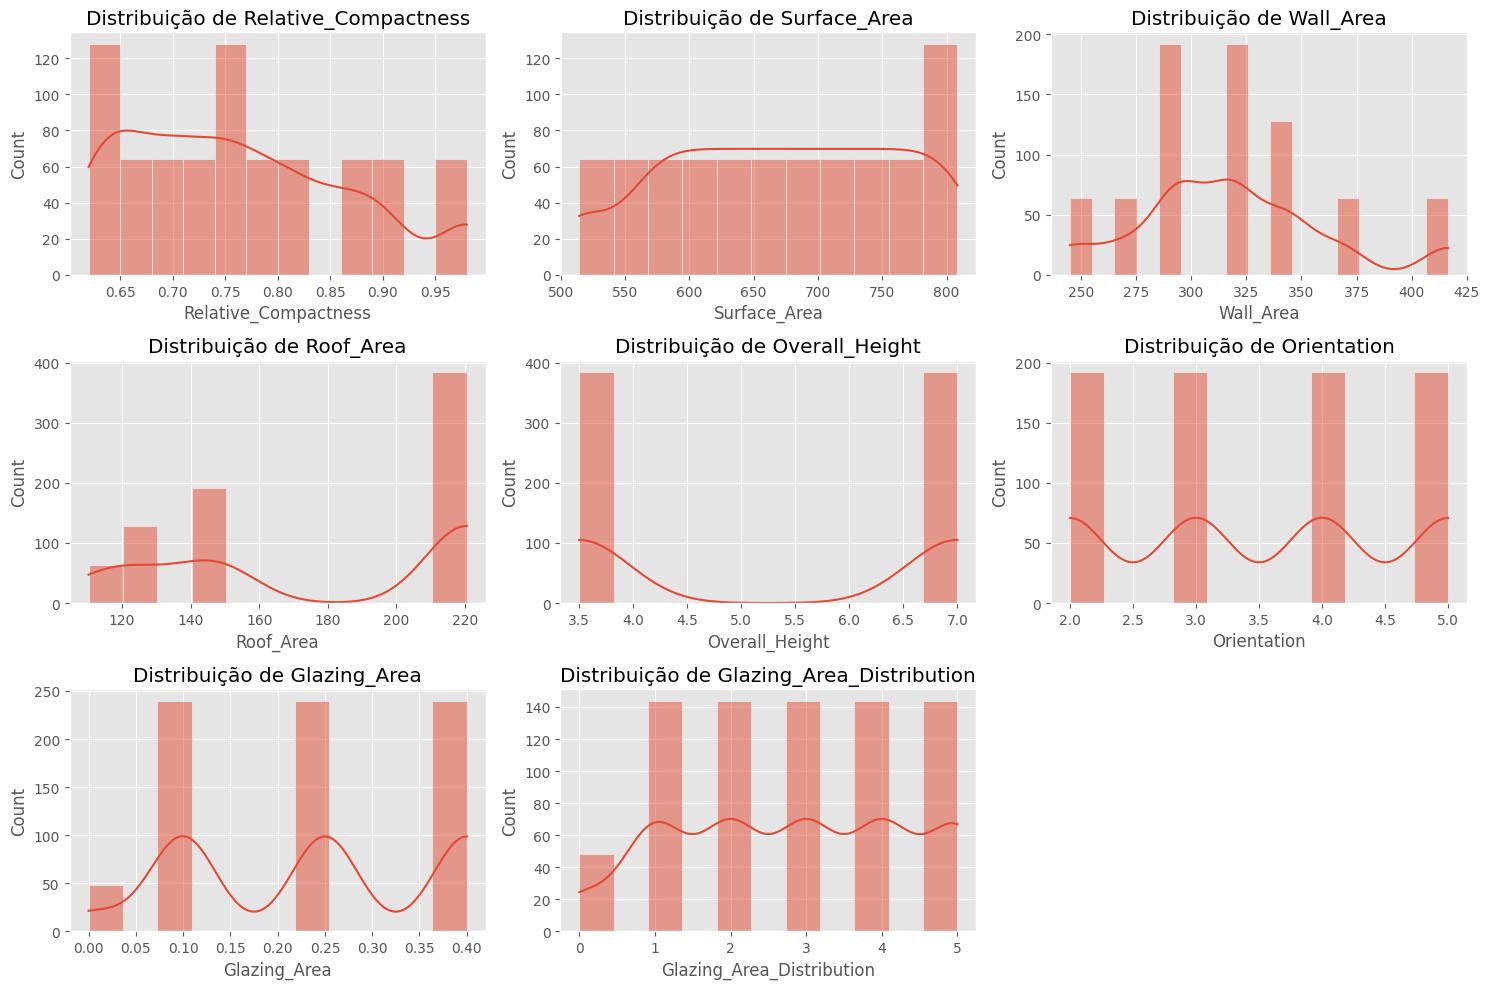

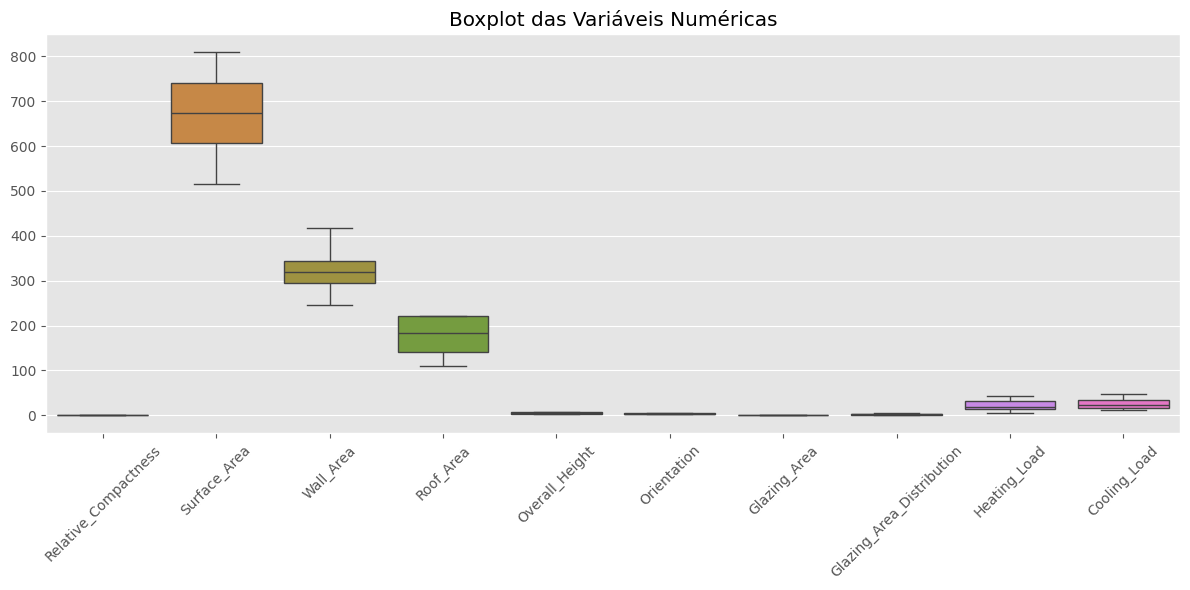

Divisão 70/30:
  Treino: 537 amostras
  Teste: 231 amostras

--> OTIMIZAÇÃO DE HIPERPARÂMETROS
--> Otimizando hiperparâmetros do Gradient Boosting...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
--> Melhores parâmetros GB: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
--> Melhor score CV: 0.1523
--> Otimizando hiperparâmetros da Decision Tree...
Fitting 5 folds for each of 135 candidates, totalling 675 fits
--> Melhores parâmetros DT: {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
--> Melhor score CV: 0.3244
--> Otimizando hiperparâmetros do SVR...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
--> Melhores parâmetros SVR: {'C': 100, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'poly'}
--> Melhor score CV: 2.3434
--> Otimizando hiperparâmetros do Random Forest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
--> Melhores parâmetros RF: {'

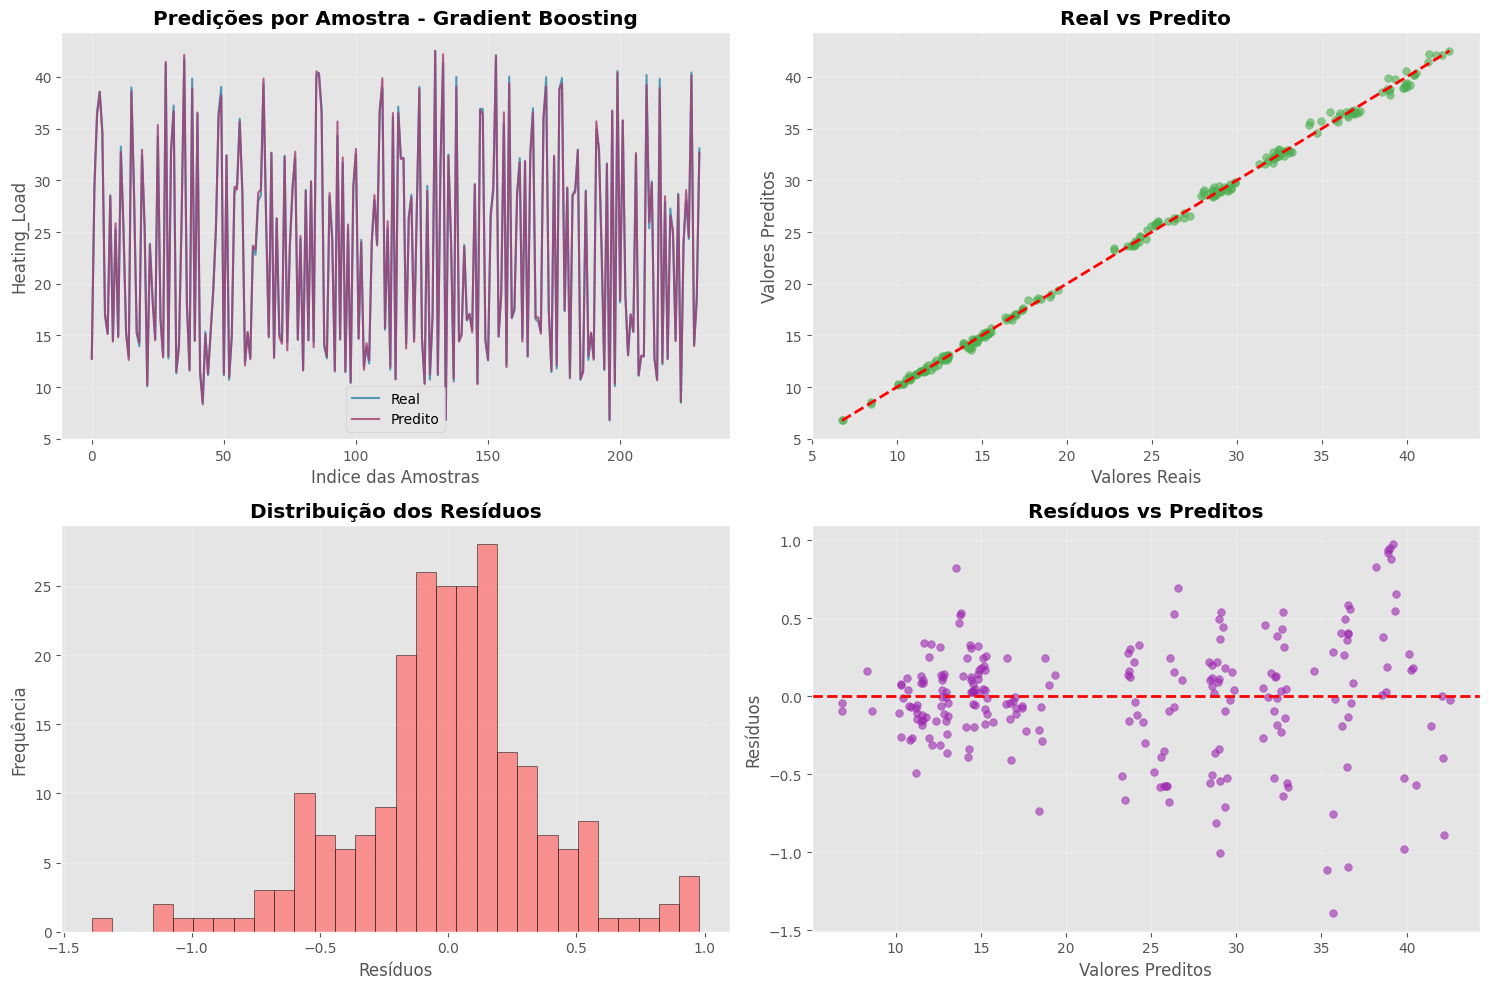

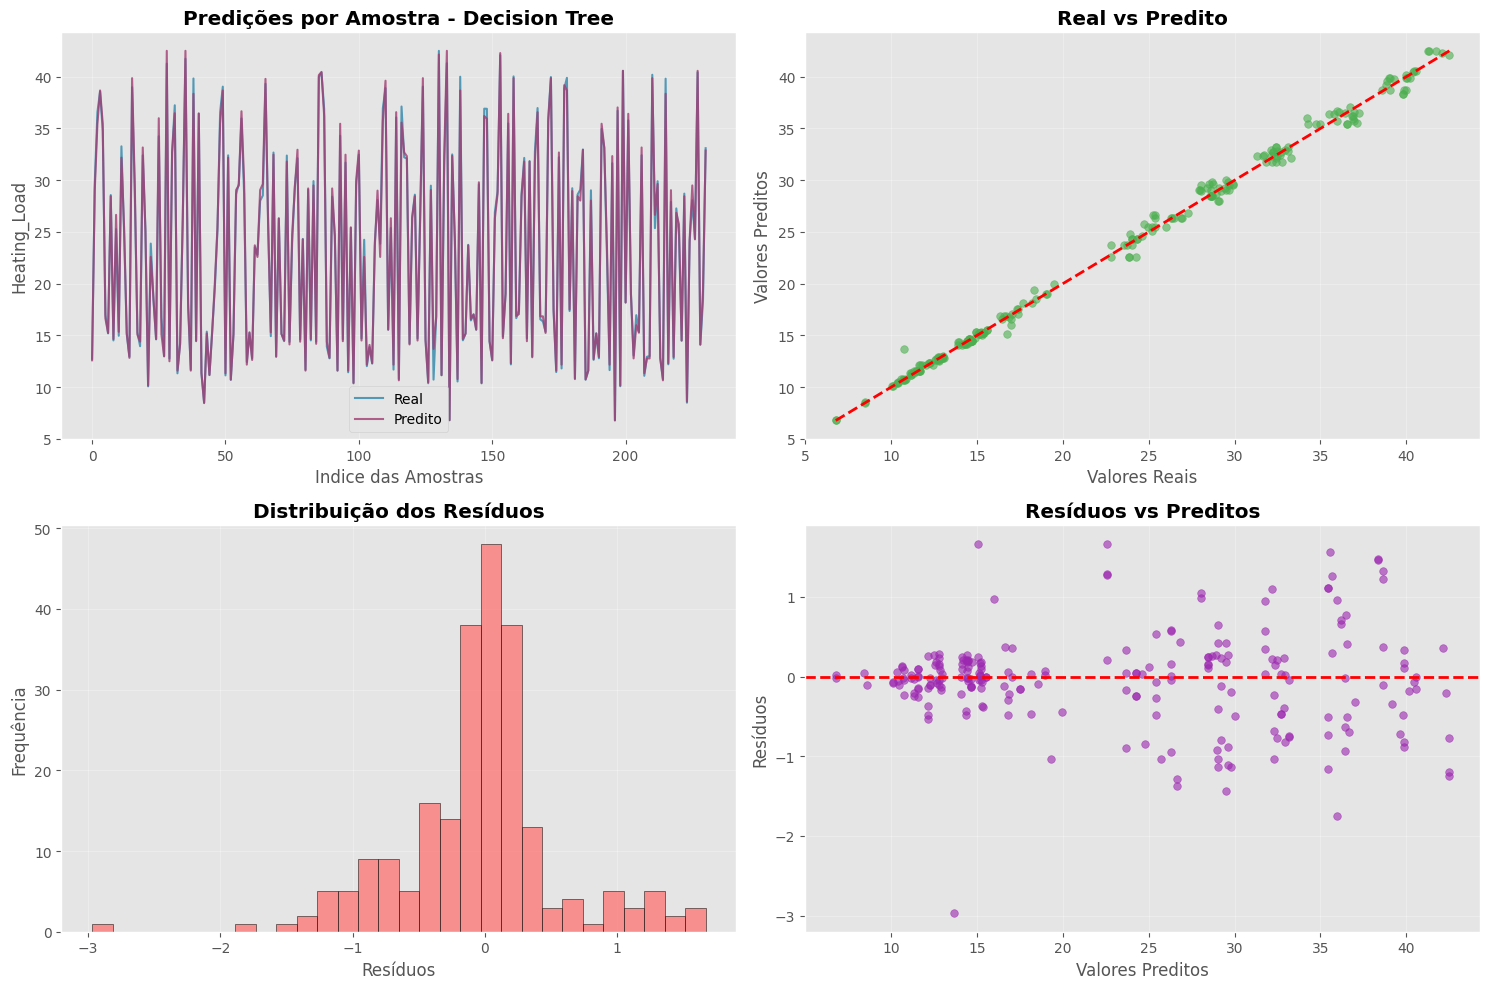

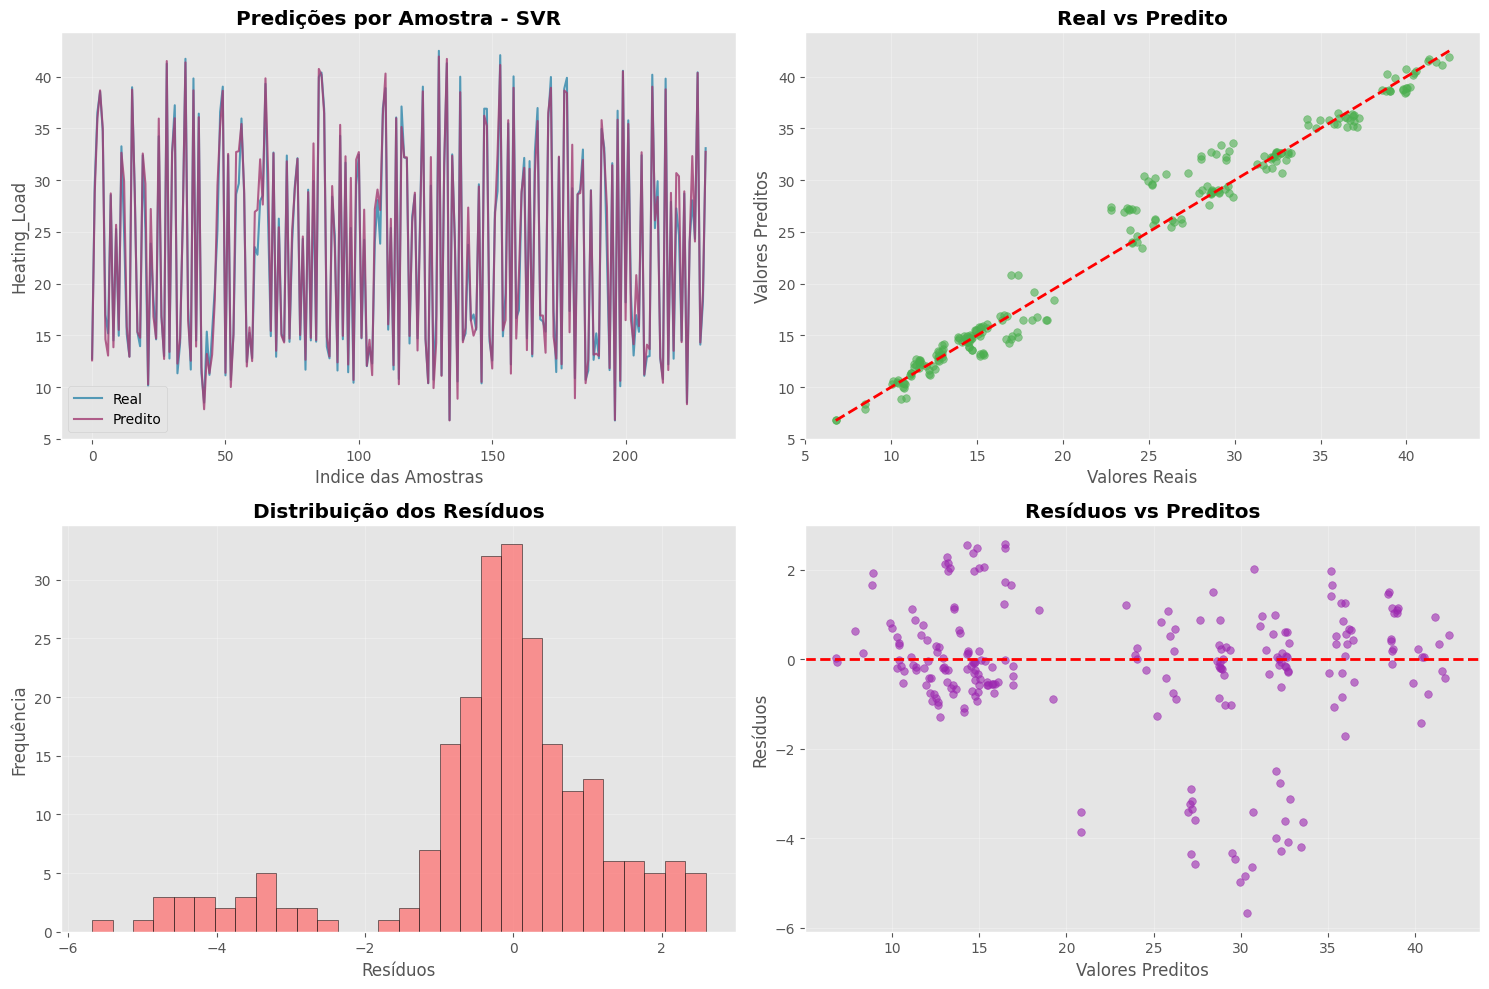

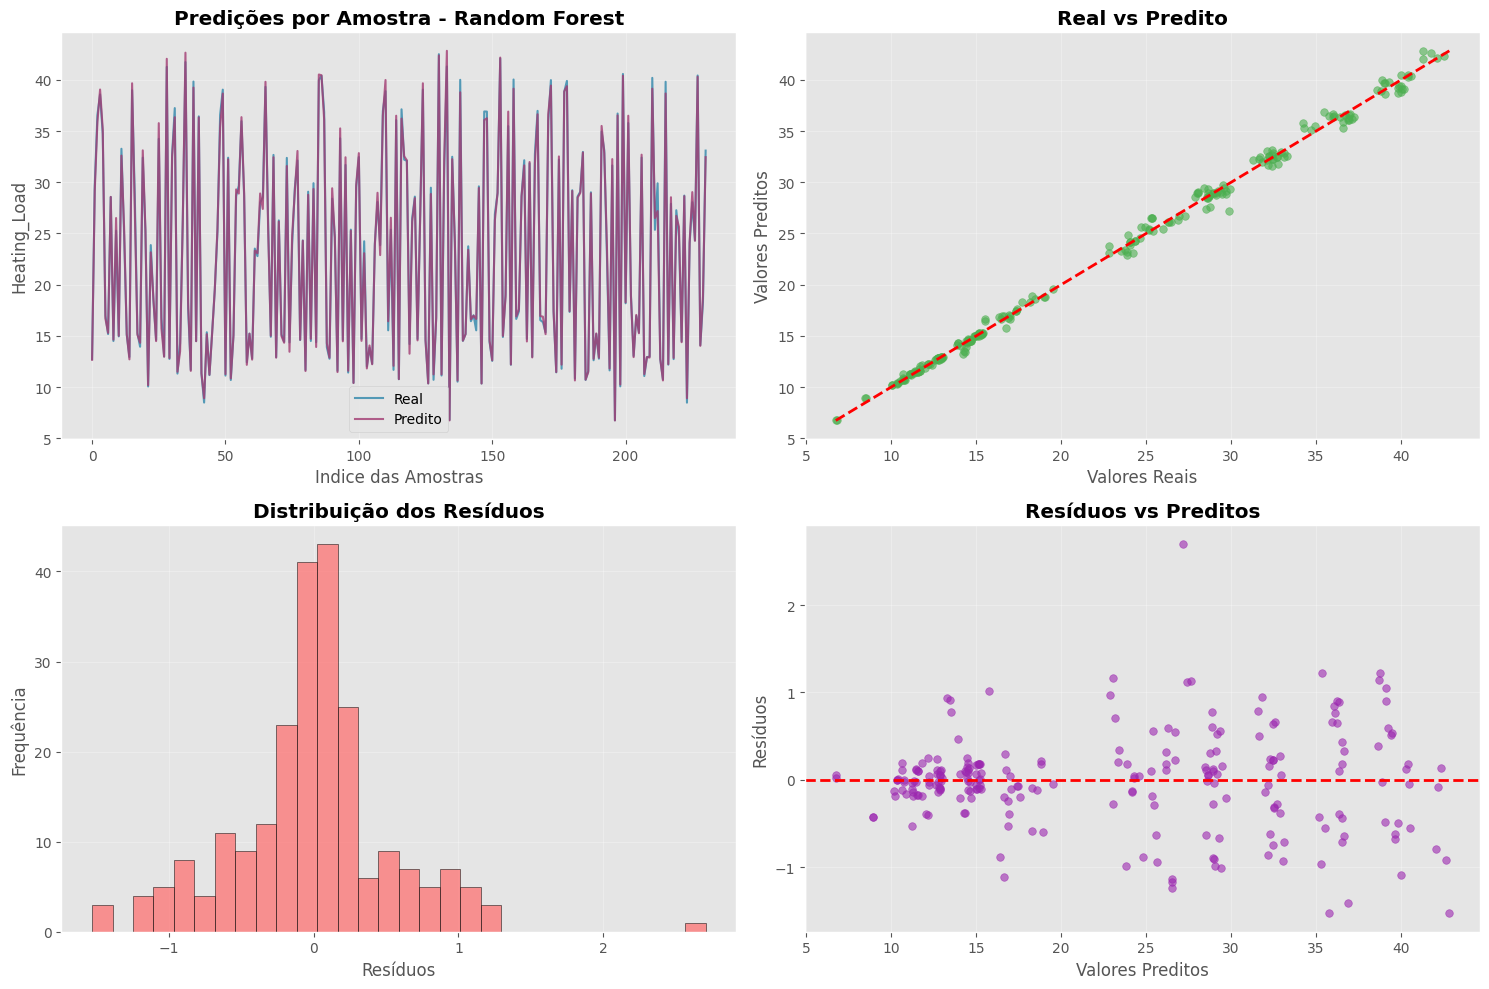


--> COMPARAÇÃO VIA BOXPLOTS


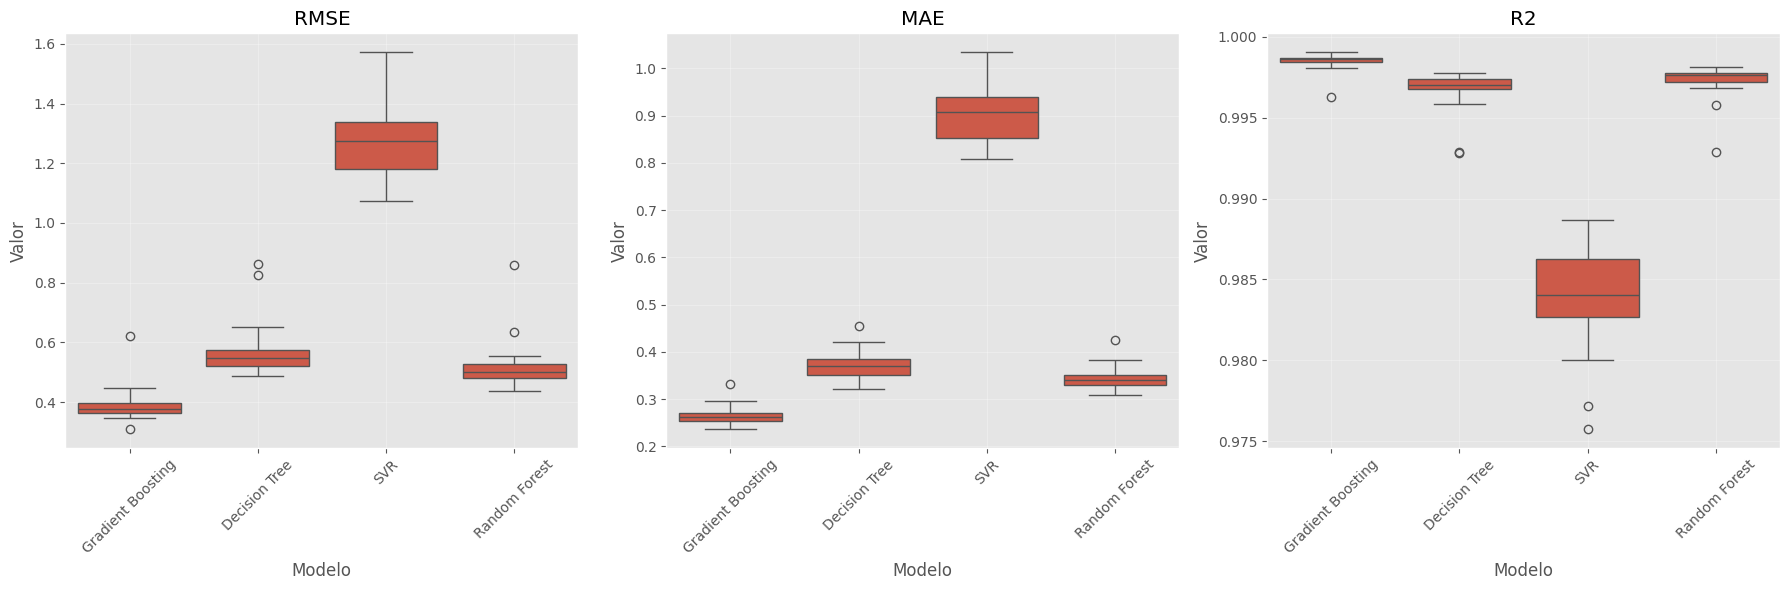


Experimento completo finalizado!


In [ ]:
class RegressaoExperimento:
    def __init__(self, dataset_path, target_column):
        self.dataset_path = dataset_path
        self.target_column = target_column
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = MinMaxScaler()
        
    def carregar_dados(self):
        df = pd.read_csv(self.dataset_path)
        
        df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 
                      'Overall_Height', 'Orientation', 'Glazing_Area', 
                      'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']
        
        targets_to_remove = ['Heating_Load', 'Cooling_Load']
        
        self.X = df.drop(targets_to_remove, axis=1).values
        self.y = df[self.target_column].values
        
        print(f"Dataset carregado: {self.X.shape[0]} amostras, {self.X.shape[1]} features")
        print(f"Target: {self.target_column}")
        print(f"Estatísticas do target:")
        print(f"  Média: {np.mean(self.y):.4f}")
        print(f"  Std: {np.std(self.y):.4f}")
        print(f"  Min: {np.min(self.y):.4f}")
        print(f"  Max: {np.max(self.y):.4f}")
        
        df_original = pd.read_csv(self.dataset_path)
        print(f"\nDados duplicados: {df_original.duplicated().sum()}")
        
    def dividir_dados(self, test_size=0.3, random_state=42):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )
        
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        print(f"Divisão 70/30:")
        print(f"  Treino: {self.X_train.shape[0]} amostras")
        print(f"  Teste: {self.X_test.shape[0]} amostras")

    def plotar_distribuicoes_iniciais(self):
        df = pd.read_csv(self.dataset_path)
        df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 
                      'Overall_Height', 'Orientation', 'Glazing_Area', 
                      'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']
        
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(df.columns[:-2], 1):
            plt.subplot(3, 3, i)
            plt.title(f"Distribuição de {col}")
            sns.histplot(df[col], kde=True)
            plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df.select_dtypes(include=np.number))
        plt.xticks(rotation=45)
        plt.title('Boxplot das Variáveis Numéricas')
        plt.tight_layout()
        plt.show()

    def otimizar_gradient_boosting(self):
        print("--> Otimizando hiperparâmetros do Gradient Boosting...")
        
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        
        grid_search = GridSearchCV(
            GradientBoostingRegressor(random_state=42), 
            param_grid, 
            cv=5, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            verbose=1
        )
        
        grid_search.fit(self.X_train_scaled, self.y_train)
        
        self.best_gb_params = grid_search.best_params_
        print(f"--> Melhores parâmetros GB: {self.best_gb_params}")
        print(f"--> Melhor score CV: {-grid_search.best_score_:.4f}")
        
        return self.best_gb_params

    def otimizar_decision_tree(self):
        print("--> Otimizando hiperparâmetros da Decision Tree...")
        
        param_grid = {
            'max_depth': [4, 6, 8, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
        
        grid_search = GridSearchCV(
            DecisionTreeRegressor(random_state=42), 
            param_grid, 
            cv=5, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            verbose=1
        )
        
        grid_search.fit(self.X_train, self.y_train)
        
        self.best_dt_params = grid_search.best_params_
        print(f"--> Melhores parâmetros DT: {self.best_dt_params}")
        print(f"--> Melhor score CV: {-grid_search.best_score_:.4f}")
        
        return self.best_dt_params

    def otimizar_svr(self):
        print("--> Otimizando hiperparâmetros do SVR...")
        
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf', 'linear', 'poly'],
            'epsilon': [0.01, 0.1, 0.2]
        }
        
        grid_search = GridSearchCV(
            SVR(),
            param_grid,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(self.X_train_scaled, self.y_train)
        
        self.best_svr_params = grid_search.best_params_
        print(f"--> Melhores parâmetros SVR: {self.best_svr_params}")
        print(f"--> Melhor score CV: {-grid_search.best_score_:.4f}")
        
        return self.best_svr_params

    def otimizar_random_forest(self):
        print("--> Otimizando hiperparâmetros do Random Forest...")
        
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
        
        grid_search = GridSearchCV(
            RandomForestRegressor(random_state=42),
            param_grid,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(self.X_train, self.y_train)
        
        self.best_rf_params = grid_search.best_params_
        print(f"--> Melhores parâmetros RF: {self.best_rf_params}")
        print(f"--> Melhor score CV: {-grid_search.best_score_:.4f}")
        
        return self.best_rf_params

    def executar_experimentos_gb(self, n_seeds=30):
        print("--> Executando experimentos Gradient Boosting (30 sementes)...")
        
        resultados = {
            'rmse': [], 'mae': [], 'r2': [],
            'y_tests': [], 'y_preds': []
        }
        
        for seed in range(1, n_seeds + 1):
            X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
                self.X, self.y, test_size=0.3, random_state=seed
            )
            
            scaler_exp = MinMaxScaler()
            X_train_scaled = scaler_exp.fit_transform(X_train_exp)
            X_test_scaled = scaler_exp.transform(X_test_exp)
            
            model = GradientBoostingRegressor(
                **self.best_gb_params,
                random_state=seed
            )
            
            model.fit(X_train_scaled, y_train_exp)
            y_pred = model.predict(X_test_scaled)
            
            rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred))
            mae = mean_absolute_error(y_test_exp, y_pred)
            r2 = r2_score(y_test_exp, y_pred)
            
            resultados['rmse'].append(rmse)
            resultados['mae'].append(mae)
            resultados['r2'].append(r2)
            resultados['y_tests'].append(y_test_exp)
            resultados['y_preds'].append(y_pred)
            
            if seed % 10 == 0:
                print(f"  Completadas {seed} execuções...")
        
        self.resultados_gb = resultados
        return resultados

    def executar_experimentos_dt(self, n_seeds=30):
        print("--> Executando experimentos Decision Tree (30 sementes)...")
        
        resultados = {
            'rmse': [], 'mae': [], 'r2': [],
            'y_tests': [], 'y_preds': []
        }
        
        for seed in range(1, n_seeds + 1):
            X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
                self.X, self.y, test_size=0.3, random_state=seed
            )
            
            model = DecisionTreeRegressor(
                **self.best_dt_params,
                random_state=seed
            )
            
            model.fit(X_train_exp, y_train_exp)
            y_pred = model.predict(X_test_exp)
            
            rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred))
            mae = mean_absolute_error(y_test_exp, y_pred)
            r2 = r2_score(y_test_exp, y_pred)
            
            resultados['rmse'].append(rmse)
            resultados['mae'].append(mae)
            resultados['r2'].append(r2)
            resultados['y_tests'].append(y_test_exp)
            resultados['y_preds'].append(y_pred)
            
            if seed % 10 == 0:
                print(f"  Completadas {seed} execuções...")
        
        self.resultados_dt = resultados
        return resultados

    def executar_experimentos_svr(self, n_seeds=30):
        print("--> Executando experimentos SVR (30 sementes)...")
        
        resultados = {
            'rmse': [], 'mae': [], 'r2': [],
            'y_tests': [], 'y_preds': []
        }
        
        for seed in range(1, n_seeds + 1):
            X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
                self.X, self.y, test_size=0.3, random_state=seed
            )
            
            scaler_exp = MinMaxScaler()
            X_train_scaled = scaler_exp.fit_transform(X_train_exp)
            X_test_scaled = scaler_exp.transform(X_test_exp)
            
            model = SVR(**self.best_svr_params)
            model.fit(X_train_scaled, y_train_exp)
            y_pred = model.predict(X_test_scaled)
            
            rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred))
            mae = mean_absolute_error(y_test_exp, y_pred)
            r2 = r2_score(y_test_exp, y_pred)
            
            resultados['rmse'].append(rmse)
            resultados['mae'].append(mae)
            resultados['r2'].append(r2)
            resultados['y_tests'].append(y_test_exp)
            resultados['y_preds'].append(y_pred)
            
            if seed % 10 == 0:
                print(f"  Completadas {seed} execuções...")
        
        self.resultados_svr = resultados
        return resultados

    def executar_experimentos_rf(self, n_seeds=30):
        print("--> Executando experimentos Random Forest (30 sementes)...")
        
        resultados = {
            'rmse': [], 'mae': [], 'r2': [],
            'y_tests': [], 'y_preds': []
        }
        
        for seed in range(1, n_seeds + 1):
            X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
                self.X, self.y, test_size=0.3, random_state=seed
            )
            
            model = RandomForestRegressor(**self.best_rf_params, random_state=seed)
            model.fit(X_train_exp, y_train_exp)
            y_pred = model.predict(X_test_exp)
            
            rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred))
            mae = mean_absolute_error(y_test_exp, y_pred)
            r2 = r2_score(y_test_exp, y_pred)
            
            resultados['rmse'].append(rmse)
            resultados['mae'].append(mae)
            resultados['r2'].append(r2)
            resultados['y_tests'].append(y_test_exp)
            resultados['y_preds'].append(y_pred)
            
            if seed % 10 == 0:
                print(f"  Completadas {seed} execuções...")
        
        self.resultados_rf = resultados
        return resultados

    def imprimir_resultados_em_tabela(self):
        print("\n" + "="*120)
        print("--> TABELA DE RESULTADOS MÉDIOS - TODOS OS MODELOS (30 EXECUÇÕES)")
        print("="*120)
        
        modelos_stats = {}
        modelos_nomes = {
            'gb': 'Gradient Boosting',
            'dt': 'Decision Tree',
            'svr': 'SVR',
            'rf': 'Random Forest'
        }
        
        for modelo_key, modelo_nome in modelos_nomes.items():
            if hasattr(self, f'resultados_{modelo_key}'):
                resultados = getattr(self, f'resultados_{modelo_key}')
                modelos_stats[modelo_nome] = {}
                
                for metrica in ['rmse', 'mae', 'r2']:
                    modelos_stats[modelo_nome][metrica] = {
                        'media': np.mean(resultados[metrica]),
                        'std': np.std(resultados[metrica]),
                        'min': np.min(resultados[metrica]),
                        'max': np.max(resultados[metrica])
                    }
        
        df_resultados = pd.DataFrame({
            'Métrica': ['RMSE', 'MAE', 'R²']
        })
        
        for modelo_nome in modelos_stats.keys():
            df_resultados[f'{modelo_nome}_Média'] = [
                f"{modelos_stats[modelo_nome]['rmse']['media']:.4f}",
                f"{modelos_stats[modelo_nome]['mae']['media']:.4f}",
                f"{modelos_stats[modelo_nome]['r2']['media']:.4f}"
            ]
            df_resultados[f'{modelo_nome}_Std'] = [
                f"±{modelos_stats[modelo_nome]['rmse']['std']:.4f}",
                f"±{modelos_stats[modelo_nome]['mae']['std']:.4f}",
                f"±{modelos_stats[modelo_nome]['r2']['std']:.4f}"
            ]
        
        print(df_resultados.to_string(index=False))
        
        print("\n" + "-"*80)
        print("--> ESTATÍSTICAS ADICIONAIS")
        print("-"*80)
        
        df_minmax = pd.DataFrame({
            'Métrica': ['RMSE', 'MAE', 'R²']
        })
        
        for modelo_nome in modelos_stats.keys():
            df_minmax[f'{modelo_nome}_Min'] = [
                f"{modelos_stats[modelo_nome]['rmse']['min']:.4f}",
                f"{modelos_stats[modelo_nome]['mae']['min']:.4f}",
                f"{modelos_stats[modelo_nome]['r2']['min']:.4f}"
            ]
            df_minmax[f'{modelo_nome}_Max'] = [
                f"{modelos_stats[modelo_nome]['rmse']['max']:.4f}",
                f"{modelos_stats[modelo_nome]['mae']['max']:.4f}",
                f"{modelos_stats[modelo_nome]['r2']['max']:.4f}"
            ]
        
        print(df_minmax.to_string(index=False))

    def plotar_visualizacoes_completas(self, resultados, nome_modelo):
        y_test = resultados['y_tests'][0]
        y_pred = resultados['y_preds'][0]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        max_points = min(500, len(y_test))
        indices = np.linspace(0, len(y_test)-1, max_points, dtype=int)
        x_plot = np.arange(max_points)
        
        axes[0,0].plot(x_plot, y_test[indices], color='#2E86AB', linewidth=1.5, label='Real', alpha=0.8)
        axes[0,0].plot(x_plot, y_pred[indices], color='#A23B72', linewidth=1.5, label='Predito', alpha=0.8)
        axes[0,0].set_title(f'Predições por Amostra - {nome_modelo}', fontweight='bold')
        axes[0,0].set_xlabel('Indice das Amostras')
        axes[0,0].set_ylabel(self.target_column)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        axes[0,1].scatter(y_test, y_pred, alpha=0.6, color='#4CAF50', s=30)
        min_val, max_val = min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))
        axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        axes[0,1].set_title('Real vs Predito', fontweight='bold')
        axes[0,1].set_xlabel('Valores Reais')
        axes[0,1].set_ylabel('Valores Preditos')
        axes[0,1].grid(True, alpha=0.3)
        
        residuos = y_test - y_pred
        axes[1,0].hist(residuos, bins=30, alpha=0.7, color='#FF6B6B', edgecolor='black')
        axes[1,0].set_title('Distribuição dos Resíduos', fontweight='bold')
        axes[1,0].set_xlabel('Resíduos')
        axes[1,0].set_ylabel('Frequência')
        axes[1,0].grid(True, alpha=0.3)
        
        axes[1,1].scatter(y_pred, residuos, alpha=0.6, color='#9C27B0', s=30)
        axes[1,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
        axes[1,1].set_title('Resíduos vs Preditos', fontweight='bold')
        axes[1,1].set_xlabel('Valores Preditos')
        axes[1,1].set_ylabel('Resíduos')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def plotar_comparacao_modelos(self):
        metricas = ['rmse', 'mae', 'r2']
        
        dados_plot = []
        
        if hasattr(self, 'resultados_gb'):
            for metrica in metricas:
                for valor in self.resultados_gb[metrica]:
                    dados_plot.append({'Modelo': 'Gradient Boosting', 'Métrica': metrica.upper(), 'Valor': valor})
        
        if hasattr(self, 'resultados_dt'):
            for metrica in metricas:
                for valor in self.resultados_dt[metrica]:
                    dados_plot.append({'Modelo': 'Decision Tree', 'Métrica': metrica.upper(), 'Valor': valor})
        
        if hasattr(self, 'resultados_svr'):
            for metrica in metricas:
                for valor in self.resultados_svr[metrica]:
                    dados_plot.append({'Modelo': 'SVR', 'Métrica': metrica.upper(), 'Valor': valor})
        
        if hasattr(self, 'resultados_rf'):
            for metrica in metricas:
                for valor in self.resultados_rf[metrica]:
                    dados_plot.append({'Modelo': 'Random Forest', 'Métrica': metrica.upper(), 'Valor': valor})
        
        df_plot = pd.DataFrame(dados_plot)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for i, metrica in enumerate(['RMSE', 'MAE', 'R2']):
            data = df_plot[df_plot['Métrica'] == metrica]
            sns.boxplot(data=data, x='Modelo', y='Valor', ax=axes[i])
            axes[i].set_title(f'{metrica}')
            axes[i].grid(True, alpha=0.3)
            axes[i].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

    def executar_experimento_completo(self):
        print("--> INICIANDO EXPERIMENTO COMPLETO DE REGRESSÃO")
        print("--> Algoritmos: Gradient Boosting, Decision Tree, SVR, Random Forest")
        print(f"--> Target: {self.target_column}")
        print("="*80)
        
        self.carregar_dados()
        
        print("\n" + "="*80)
        print("--> VISUALIZAÇÕES INICIAIS")
        print("="*80)
        self.plotar_distribuicoes_iniciais()
        
        self.dividir_dados()
        
        print("\n" + "="*80)
        print("--> OTIMIZAÇÃO DE HIPERPARÂMETROS")
        print("="*80)
        self.otimizar_gradient_boosting()
        self.otimizar_decision_tree()
        self.otimizar_svr()
        self.otimizar_random_forest()
        
        print("\n" + "="*80)
        print("--> EXECUTANDO 30 TESTES COM SEEDS 1-30")
        print("="*80)
        self.executar_experimentos_gb()
        self.executar_experimentos_dt()
        self.executar_experimentos_svr()
        self.executar_experimentos_rf()
        
        self.imprimir_resultados_em_tabela()
        
        print("\n" + "="*80)
        print("--> VISUALIZAÇÕES DOS RESULTADOS")
        print("="*80)
        
        self.plotar_visualizacoes_completas(self.resultados_gb, "Gradient Boosting")
        self.plotar_visualizacoes_completas(self.resultados_dt, "Decision Tree")
        self.plotar_visualizacoes_completas(self.resultados_svr, "SVR")
        self.plotar_visualizacoes_completas(self.resultados_rf, "Random Forest")
        
        print("\n" + "="*80)
        print("--> COMPARAÇÃO VIA BOXPLOTS")
        print("="*80)
        self.plotar_comparacao_modelos()
        
        print("\nExperimento completo finalizado!")

experimento = RegressaoExperimento("EnergyEficient/ENB2012_data.csv", "Heating_Load")
experimento.executar_experimento_completo()